<h1 align="center"><font color="yellow">DeepLearning.AI: Dense Retrieval</font></h1>

<font color="yellow">Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro</font>

# Setup

In [ ]:
# %pip install cohere 
# %pip install weaviate-client Annoy

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [2]:
import cohere
co = cohere.Client(os.environ['COHERE_API_KEY'])


In [3]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key=os.environ['WEAVIATE_API_KEY'])

In [4]:
Eddy_COHERE_API_KEY = os.environ["COHERE_API_KEY"]
Eddy_WEAVIATE_API_KEY = os.environ["WEAVIATE_API_KEY"]

Eddy_HUGGINGFACEHUB_API_KEY = os.environ["HUGGINGFACEHUB_API_KEY"]
Eddy_OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [5]:
client = weaviate.Client(
    url="https://eddy2-bb6y5qj0.weaviate.network",
    auth_client_secret=weaviate.AuthApiKey(api_key=Eddy_WEAVIATE_API_KEY),
    additional_headers={
        "X-Cohere-Api-Key": Eddy_COHERE_API_KEY,
    }
)
client.is_ready() #check if True

True

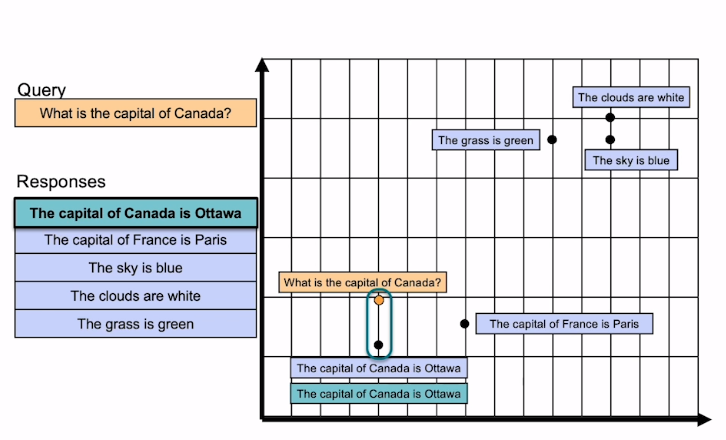

# Parte 1: <font color="red">Vector Database for semantic Search</font>

In [6]:
def dense_retrieval(query, 
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):

    nearText = {"concepts": [query]}
    
    # To filter by language
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result

```
from utils import print_result

# Bacic Query:
query = "Who wrote Hamlet?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

# Medium Query:
query = "What is the capital of Canada?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)


from utils import keyword_search

query = "What is the capital of Canada?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)


# Complicated Query:

from utils import keyword_search

query = "Tallest person in history?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)

query = "Tallest person in history"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

query = "أطول رجل في التاريخ"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

query = "film about a time travel paradox"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)
```

# Parte 2: <font color="red">Building Semantic Search from Scratch</font>

## Get the text archive:

In [8]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
import re

# Obtenha o arquivo de texto:
text = """
Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.
It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.
Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.

Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.
Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.
Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.
Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.
Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects.

Interstellar premiered on October 26, 2014, in Los Angeles.
In the United States, it was first released on film stock, expanding to venues using digital projectors.
The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014.
It received acclaim for its performances, direction, screenplay, musical score, visual effects, ambition, themes, and emotional weight.
It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics. Since its premiere, Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all time.
Interstellar was nominated for five awards at the 87th Academy Awards, winning Best Visual Effects, and received numerous other accolades"""


## Chunking:

In [9]:
# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])


In [10]:
texts

array(['Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan',
       'It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine',
       'Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind',
       'Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007',
       'Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar',
       'Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm',
       'Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles',

In [11]:
# Split into a list of paragraphs
texts = text.split('\n\n')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [12]:
texts

array(['Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.\nIt stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.\nSet in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.',
       'Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.\nCaltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.\nCinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.\nPrincipal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.\nInterstellar uses extensive practical 

In [13]:
# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])


In [14]:
texts

array(['Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan',
       'It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine',
       'Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind',
       'Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007',
       'Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar',
       'Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm',
       'Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles',

In [15]:
title = 'Interstellar (film)'

texts = np.array([f"{title} {t}" for t in texts])


In [16]:
texts

array(['Interstellar (film) Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan',
       'Interstellar (film) It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine',
       'Interstellar (film) Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind',
       'Interstellar (film) Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007',
       'Interstellar (film) Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar',
       'Interstellar (film) Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format

## Get the embeddings:

In [20]:
response = co.embed(texts=texts.tolist()).embeddings


In [21]:
embeds = np.array(response)
embeds.shape

(15, 4096)

## Create the search index:

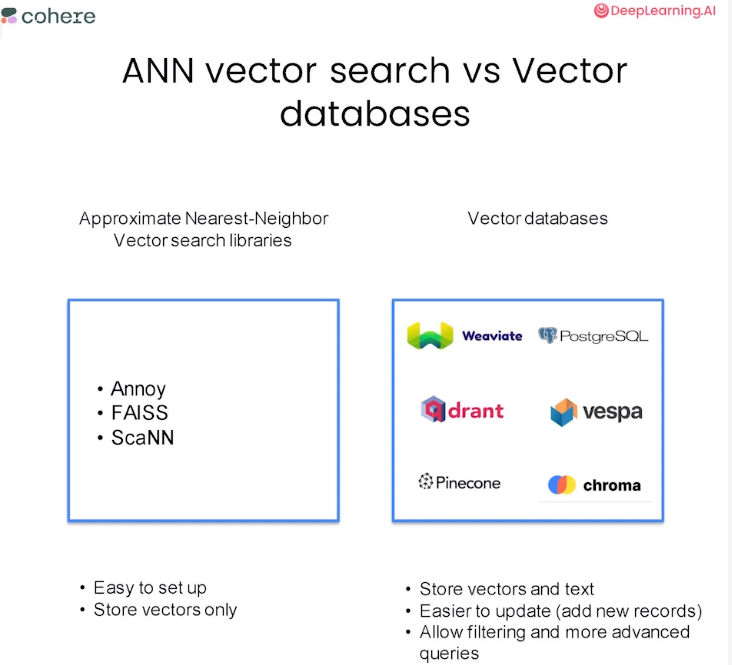

In [25]:
search_index = AnnoyIndex(embeds.shape[1], 'angular') # angular é a métrica de distância (ou seja: distância COSSENO)
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i]) # i -> identificador do item (geralmente o índice) e embeds[i] -> é o vetor Embeddings correspondente

search_index.build(10) # 10 trees (Mais árvores busca mais precisa). Após adicionar todos os itens ao índice de pesquisa, o método build é chamado para construir o índice.
search_index.save('test.ann') # Salva o índice construído.


True

In [26]:
pd.set_option('display.max_colwidth', None) # Isso ajusta as opções de exibição do pandas para que o conteúdo de todas as colunas possa ser exibido sem ser truncado.

def search(query):

  # Get the query's embedding
  query_embed = co.embed(texts=[query]).embeddings

  # Retrieve the nearest neighbors
  similar_item_ids = search_index.get_nns_by_vector(query_embed[0],
                                                    3,
                                                  include_distances=True) # Com a métrica 'angular', a distância retornada será um valor entre 0 e 2, onde 0 indica que os vetores são idênticos e 2 indica que eles estão completamente opostos. (VERIFICAR!!!)
  # Format the results
  results = pd.DataFrame(data={'texts': texts[similar_item_ids[0]],
                              'distance': similar_item_ids[1]})

  print(texts[similar_item_ids[0]]) # 'texts' é uma lista/array que contém os textos dos itens indexados
    
  return results

In [27]:
query = "How much did the film make?"
search(query)

['Interstellar (film) The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014'
 'Interstellar (film) Interstellar premiered on October 26, 2014, in Los Angeles'
 'Interstellar (film) In the United States, it was first released on film stock, expanding to venues using digital projectors']


,texts,distance
0,"Interstellar (film) The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014",1.019055
1,"Interstellar (film) Interstellar premiered on October 26, 2014, in Los Angeles",1.144950
2,"Interstellar (film) In the United States, it was first released on film stock, expanding to venues using digital projectors",1.167268


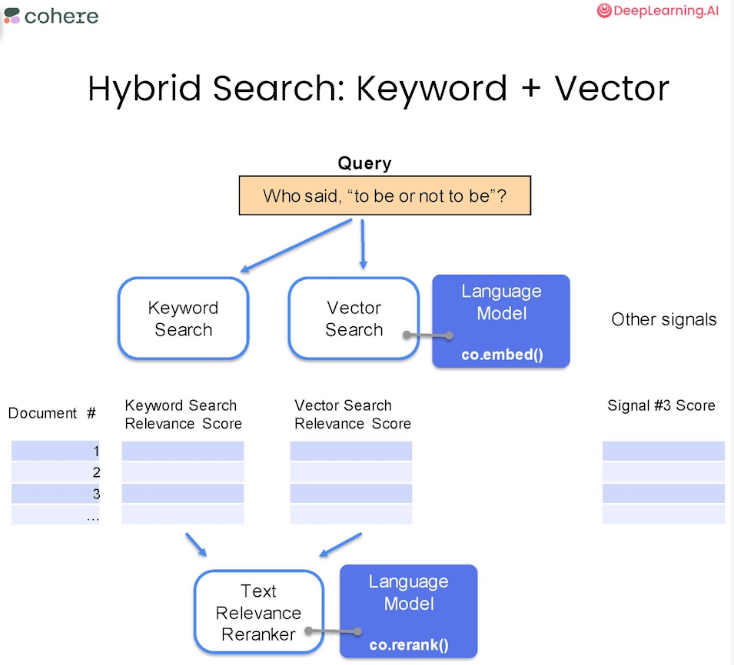